In [3]:
import geoopt
import torch
import numpy as np
import random
import logging
import json

import sys
sys.path.insert(0, "../src")
from models.hyperbolic import ManifoldSkipGram

In [393]:
idx2song = json.load(open("../models/lorentz/idx2song.json"))
idx2song = {int(k):v for k,v in idx2song.items()}
song2idx = {v:k for k,v in idx2song.items()}

In [274]:
NUM_EMBEDDING = len(idx2song)
print(NUM_EMBEDDING)
EMBEDDING_DIM = 16

manifold = geoopt.manifolds.Lorentz()
model = ManifoldSkipGram(manifold, NUM_EMBEDDING, EMBEDDING_DIM, similarity="distance")
model.load_state_dict(torch.load("../models/lorentz/model.pt"))

159957


<All keys matched successfully>

In [275]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.geometry.hyperboloid import Hyperboloid
import geomstats

In [276]:
weights = model.encoder.w.detach().numpy()
manifold = Hyperboloid(dim=weights.shape[-1]-1)

In [277]:
geomstats.backend.all(manifold.belongs(weights))

True

In [278]:
mean = FrechetMean(metric=manifold.metric)
mean.fit(weights)

FrechetMean(metric=<geomstats.geometry.hyperboloid.HyperboloidMetric object at 0x7f1c2d96fb80>,
            point_type='vector')

In [279]:
tpca = TangentPCA(metric=manifold.metric, n_components=2)
tpca.fit(weights, base_point=mean.estimate_)
projected = tpca.transform(weights)

In [280]:
pole = np.array([1] + [0] * 15)
manifold.belongs(pole)

True

In [281]:
#distances = manifold.metric.dist(mean.estimate_, weights)
distances = manifold.metric.dist(pole, weights)

Text(0.5, 0, 'Log frequency of item')

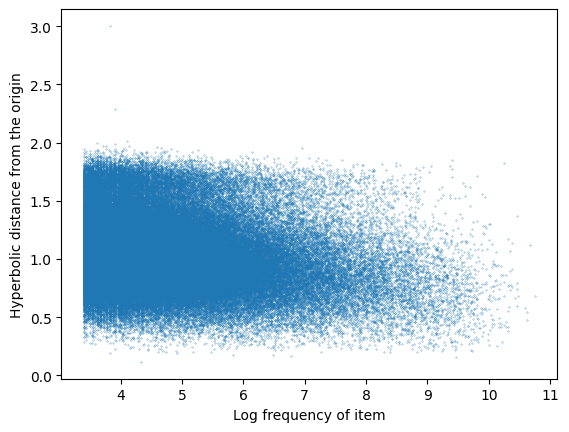

In [394]:
import matplotlib.pyplot as plt
freqs = json.load(open("../models/hyperbolic/frequencies.json"))
freqs = {int(k): v for k,v in freqs.items()}
colors = np.log([freqs[id_] for id_ in song2idx.values()])
plt.scatter(colors, distances, s=0.05)
plt.ylabel("Hyperbolic distance from the origin")
plt.xlabel("Log frequency of item")

In [362]:
import os


import sys
sys.path.insert(0, "../src/")
from models.transformer.loader import PlaylistDataset


# utils to create this file list

def get_file_list(base):
    return [os.path.join(base, f) for f in os.listdir(base) if ".json" in f]

#files = get_file_list("../data/processed/")[:2]
files = ["../data/processed/chunk_18.json", "../data/processed/chunk_19.json"]
dataset = PlaylistDataset(files, 50_000)
len(files), files

(2, ['../data/processed/chunk_18.json', '../data/processed/chunk_19.json'])

# Qrels

In [372]:
from tqdm import tqdm

MIN_LENGTH = 10
data = {}
i = 0

for playlist in tqdm(dataset):
    split = min(30, len(playlist) // 2)
    part1, part2 = playlist[:split], set(playlist[split:])
    if len(part2) < MIN_LENGTH:
        continue
    data[i] = {
        "part2": part2,
        "part1": part1
    }
    i += 1
len(data)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 40767.53it/s]


84792

In [373]:
qrels = {k: {s: 1 for s in v["part2"]} for k,v in data.items()}

In [374]:
with open("../data/qrels.json", "w") as f:
    json.dump(qrels, f)

# Runs

In [391]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter


class ManifoldDistanceNearestNeighbors:
    
    def __init__(self, manifold, k):
        self.k = k
        self.manifold = manifold
        
    def fit(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        self.x = x
        self.x0 = torch.zeros(x.shape[1]).to(x.device)
        
    @torch.no_grad()
    def _distances(self, x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x)
        if len(x.shape) > 1:
            return self.manifold.dist2(x[:,None,:], self.x)
        return self.manifold.dist2(self.x, x)
    
    def kneighbors(self, x, return_distance=True, include_self=False):
        distances = self._distances(x)
        order = np.argsort(distances, axis=-1)
        offset, k = 0 if include_self else 1, self.k if include_self else self.k+1
        if return_distance:
            o = order[:, offset:k]
            d = torch.stack([distances[i, o[i]] for i in range(len(o))], dim=0)
            return o.cpu().numpy(), d.cpu().numpy()
        return order[:, offset:k].cpu().numpy()

class Recommender:
    
    def __init__(self, song2ids, knn, vecs):
        self.song2ids = song2ids
        self.ids2song = {v:k for k,v in song2ids.items()}
        self.known_songs = set(song2ids.keys())
        self._vecs = vecs
        self.knn = knn
        self.knn.fit(vecs)
        
    def recommend(self, songs, k=500):
        assert isinstance(songs, list), "Must provide list!"
        songs = list(filter(lambda song: song in self.known_songs, songs))
        print(len(songs))
        ids = [self.song2ids[song] for song in songs]
        vecs = self._vecs[ids]
        nns, distances = self.knn.kneighbors(vecs, return_distance=True)
        nns = nns.reshape(-1)
        distances = distances.reshape(-1)
        distances = {neigh: dist for neigh, dist in zip(nns, distances)}
        c = Counter(nns)
        rec = [idx for idx,count in c.most_common(k)]
        # convert distance to similarity score
        rec_scores = [1 / distances[r] for r in rec]
        # translate song id to uri
        rec = [self.ids2song[idx] for idx in rec]
        return rec, rec_scores
    
    
class PopularRecommender:
    
    def __init__(self, freqs, song2ids):
        c = Counter(freqs)
        ids2song = {v:k for k,v in song2ids.items()}
        self.rec = list(zip(*c.most_common(len(c))))
        self.rec[0] = [ids2song[i] for i in self.rec[0]]
        
    def recommend(self, songs, k=500):
        return self.rec[0][:k], self.rec[1][:k]

In [392]:
pr = PopularRecommender(freqs, song2idx)

KeyError: 163434

In [386]:
pr.recommend(None, 10)

((1180, 3336, 1240, 1598, 2396, 2382, 1178, 2379, 1008, 3188),
 (46574, 43447, 41309, 41079, 39987, 35202, 35138, 34999, 34922, 34657))

In [370]:
nn = ManifoldDistanceNearestNeighbors(model.encoder._manifold, 50)
r = Recommender(song2idx, nn, weights)

In [371]:
run = {}
for i, parts in tqdm(data.items()):
    part1, part2 = parts["part1"], parts["part2"]
    recs, scores = r.recommend(part1, k=500)
    entry = {song: score for song, score in zip(recs, scores)}
    run[i] = entry

  0%|                                                                                 | 1/84792 [00:00<3:03:11,  7.71it/s]

6
30


  0%|                                                                                 | 2/84792 [00:00<9:31:37,  2.47it/s]

14


  0%|                                                                                 | 3/84792 [00:00<7:56:51,  2.96it/s]

28


  0%|                                                                                 | 4/84792 [00:01<9:58:34,  2.36it/s]

22


  0%|                                                                                | 5/84792 [00:01<10:15:52,  2.29it/s]

13


  0%|                                                                                 | 6/84792 [00:02<8:49:00,  2.67it/s]

29


  0%|                                                                                | 7/84792 [00:02<10:39:34,  2.21it/s]

16


  0%|                                                                                 | 8/84792 [00:03<9:47:24,  2.41it/s]

30


  0%|                                                                                | 9/84792 [00:03<11:06:44,  2.12it/s]

30


  0%|                                                                               | 10/84792 [00:04<12:25:05,  1.90it/s]

17


  0%|                                                                                | 12/84792 [00:04<8:52:32,  2.65it/s]

9
5


  0%|                                                                                | 14/84792 [00:05<6:09:41,  3.82it/s]

10
28


  0%|                                                                                | 15/84792 [00:05<8:13:28,  2.86it/s]

15


  0%|                                                                                | 16/84792 [00:06<7:46:51,  3.03it/s]

15


  0%|                                                                                | 17/84792 [00:06<7:34:55,  3.11it/s]

30


  0%|                                                                                | 18/84792 [00:06<9:25:55,  2.50it/s]

30


  0%|                                                                               | 19/84792 [00:07<10:58:22,  2.15it/s]

17


  0%|                                                                               | 20/84792 [00:07<10:01:45,  2.35it/s]

26


  0%|                                                                               | 21/84792 [00:08<10:42:08,  2.20it/s]

4
24


  0%|                                                                                | 23/84792 [00:09<9:03:44,  2.60it/s]

22


  0%|                                                                                | 24/84792 [00:09<9:12:18,  2.56it/s]

29


  0%|                                                                               | 25/84792 [00:10<10:15:31,  2.30it/s]

11


  0%|                                                                                | 26/84792 [00:10<8:51:23,  2.66it/s]

11


  0%|                                                                                | 27/84792 [00:10<7:59:14,  2.95it/s]

27


  0%|                                                                                | 28/84792 [00:11<9:17:09,  2.54it/s]

29


  0%|                                                                               | 29/84792 [00:11<10:58:00,  2.15it/s]

24


  0%|                                                                                | 31/84792 [00:12<8:57:09,  2.63it/s]

11
30


  0%|                                                                                | 33/84792 [00:12<8:05:43,  2.91it/s]

6
24


  0%|                                                                                | 34/84792 [00:13<9:19:47,  2.52it/s]

0


RuntimeError: stack expects a non-empty TensorList